<a href="https://colab.research.google.com/github/yashgupta-7/689_project/blob/main/visualize_attention_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  if __name__ == '__main__':


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
%cd /content/gdrive/MyDrive/cs689_project
!ls

/content/gdrive/MyDrive/cs689_project
professions_data  results  winobias_data  winobias.py  winogender_data


In [4]:
model_version = "distilgpt2"
filter = "unfiltered"
fname = f"winobias_data/attention_intervention_{model_version}_{filter}_dev.json"

In [5]:
import json
with open(fname) as f:
    data = json.load(f)

In [6]:
results = data['results']
df = pd.DataFrame(results)

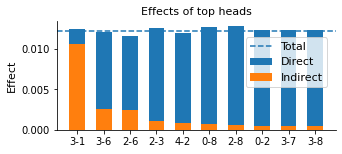

In [8]:
def topk_indices(arr, k):
    """Return indices of top-k values"""
    return (-arr).argsort(axis=None)[:k]

source = 'winobias'
k = 10
# Aggregate by head
# Convert column to 3d ndarray (num_examples x num_layers x num_heads)
indirect_by_head = np.stack(df['indirect_effect_head'].to_numpy())
direct_by_head = np.stack(df['direct_effect_head'].to_numpy())
# Average by head
mean_indirect_by_head = indirect_by_head.mean(axis=0)
mean_direct_by_head = direct_by_head.mean(axis=0)
# Select top k heads by indirect effect
topk_inds = topk_indices(mean_indirect_by_head, k)

# Aggregate by layer
# Convert column to 2d ndarray (num_examples x num_layers)
indirect_by_layer = np.stack(df['indirect_effect_layer'].to_numpy())
direct_by_layer = np.stack(df['direct_effect_layer'].to_numpy())
mean_indirect_by_layer = indirect_by_layer.mean(axis=0)
mean_direct_by_layer = direct_by_layer.mean(axis=0)
n_layers = indirect_by_layer.shape[1]

plt.rc('figure', titlesize=20)

# Plot stacked bar chart
palette = sns.color_palette()#('muted')
plt.figure(num=1, figsize=(5, 2))
topk_direct = []
topk_indirect = []
labels = []
for ind in topk_inds:
    layer, head = np.unravel_index(ind, mean_indirect_by_head.shape)
    topk_indirect.append(mean_indirect_by_head[layer, head])
    topk_direct.append(mean_direct_by_head[layer, head])
    labels.append(f'{layer}-{head}')
width = 0.6
inds = range(k)
p1 = plt.bar(inds, topk_indirect, width, linewidth=0, color=palette[1])
p2 = plt.bar(inds, topk_direct, width, bottom=topk_indirect, linewidth=0, color=palette[0])
plt.ylabel('Effect', size=11)
plt.title('Effects of top heads', fontsize=11)
plt.xticks(inds, labels, size=10)
plt.yticks(size=10)
p3 = plt.axhline(data['mean_total_effect'], linestyle='--')
plt.legend((p3, p2[0], p1[0]), ('Total', 'Direct', 'Indirect'), loc='upper right', fontsize=11,
            bbox_to_anchor=(.99, 0.90))
sns.despine()
path = 'results/attention_intervention/stacked_bar_charts'
if not os.path.exists(path):
    os.makedirs(path)
# plt.savefig(f'{path}/{source}_{model_version}_{filter}_.pdf', format='pdf')
# plt.close()
annot = False

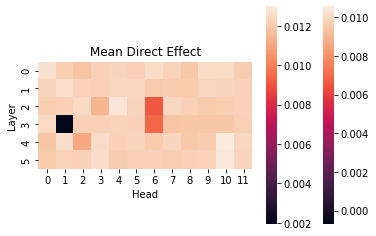

In [11]:
for effect_type in ('indirect', 'direct'):
  if effect_type == 'indirect':
      mean_effect = mean_indirect_by_head
  else:
      mean_effect = mean_direct_by_head
  ax = sns.heatmap(mean_effect, rasterized=True, annot=annot, annot_kws={"size": 9}, fmt=".2f", square=True)
  ax.set(xlabel='Head', ylabel='Layer', title=f'Mean {effect_type.capitalize()} Effect')
  plt.figure(num=1, figsize=(7, 5))
  path = f'results/attention_intervention/heat_maps_{effect_type}'
  if not os.path.exists(path):
      os.makedirs(path)
  plt.savefig(f'{path}/{source}_{model_version}_{filter}_.pdf', format='pdf')
  # plt.close()

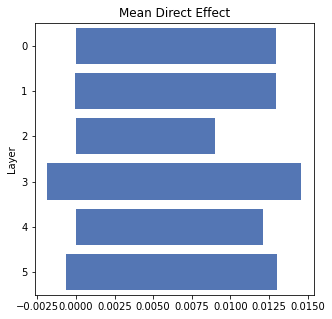

In [13]:
for effect_type in ('indirect', 'direct'):
    if effect_type == 'indirect':
        mean_effect = mean_indirect_by_layer
    else:
        mean_effect = mean_direct_by_layer
    plt.figure(num=1, figsize=(5, 5))
    ax = sns.barplot(x=mean_effect, y=list(range(n_layers)), orient="h", color="#4472C4")
    ax.set(ylabel='Layer', title=f'Mean {effect_type.capitalize()} Effect')
    path = f'results/attention_intervention/layer_{effect_type}'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}/{source}_{model_version}_{filter}.pdf', format='pdf')

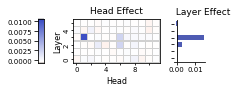

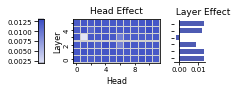

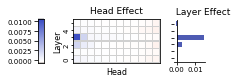

In [16]:
for do_sort in False, True:
  for effect_type in ('indirect', 'direct'):
      if effect_type == 'indirect':
          effect_head = mean_indirect_by_head
          effect_layer = mean_indirect_by_layer
          if do_sort:
              effect_head = -np.sort(-effect_head) # Sort indirect effects within each layer in descending order
      else:
          if do_sort:
              continue
          effect_head = mean_direct_by_head
          effect_layer = mean_direct_by_layer
      fig = plt.figure(figsize=(3, 2.2))
      if model_version == 'distilgpt2':
          ax1 = plt.subplot2grid((100, 85), (0, 0), colspan=62, rowspan=99)
          ax2 = plt.subplot2grid((100, 85), (32, 69), colspan=17, rowspan=35)
      elif model_version in ('gpt2', 'gpt2_random'):
          ax1 = plt.subplot2grid((100, 85), (0, 0), colspan=65, rowspan=99)
          ax2 = plt.subplot2grid((100, 85), (12, 70), colspan=15, rowspan=75)
      elif model_version == 'gpt2-medium':
          ax1 = plt.subplot2grid((100, 85), (0, 5), colspan=55, rowspan=99)
          ax2 = plt.subplot2grid((100, 85), (2, 64), colspan=17, rowspan=95)
      elif model_version == 'gpt2-large':
          ax1 = plt.subplot2grid((100, 85), (0, 5), colspan=55, rowspan=96)
          ax2 = plt.subplot2grid((100, 85), (0, 62), colspan=17, rowspan=97)
      elif model_version == 'gpt2-xl':
          ax1 = plt.subplot2grid((100, 85), (0, 5), colspan=55, rowspan=96)
          ax2 = plt.subplot2grid((100, 85), (0, 62), colspan=17, rowspan=97)
      heatmap = sns.heatmap(effect_head, center=0.0, ax=ax1, annot=annot, annot_kws={"size": 9}, fmt=".2f", square=True, cbar=False, linewidth=0.1, linecolor='#D0D0D0',
      cmap = LinearSegmentedColormap.from_list('rg', ["#F14100", "white", "#3D4FC4"], N=256))
      plt.setp(heatmap.get_yticklabels(), fontsize=7)
      plt.setp(heatmap.get_xticklabels(), fontsize=7)
      heatmap.tick_params(axis='x', pad=1, length=2)
      heatmap.tick_params(axis='y', pad=1, length=2)
      heatmap.yaxis.labelpad = 2
      heatmap.invert_yaxis()
      if model_version != 'gpt2-xl':
          for i, label in enumerate(heatmap.xaxis.get_ticklabels()):
              if i%2 == 1:
                  label.set_visible(False)
          for i, label in enumerate(heatmap.yaxis.get_ticklabels()):
              if i%2 == 1:
                  label.set_visible(False)
      if do_sort:
          heatmap.axes.get_xaxis().set_ticks([])
      else:
          if model_version == 'gpt2-xl':
              every_nth = 2
              for n, label in enumerate(ax1.xaxis.get_ticklabels()):
                  if n % every_nth != 0:
                      label.set_visible(False)
              for n, label in enumerate(ax1.yaxis.get_ticklabels()):
                  if n % every_nth != 0:
                      label.set_visible(False)
      # split axes of heatmap to put colorbar
      ax_divider = make_axes_locatable(ax1)
      if model_version in ('gpt2-large', 'gpt2-xl'):
          cax = ax_divider.append_axes('left', size='7%', pad='45%')
      else:
          cax = ax_divider.append_axes('left', size='7%', pad='33%')
      # # make colorbar for heatmap.
      # # Heatmap returns an axes obj but you need to get a mappable obj (get_children)
      cbar = colorbar(ax1.get_children()[0], cax=cax, orientation='vertical')
      cax.yaxis.set_ticks_position('left')
      cbar.solids.set_edgecolor("face")
      cbar.ax.tick_params(labelsize=7, length=4, pad=2)
      ax1.set_title('Head Effect', size=9)
      ax1.set_xlabel('Head', size=8)
      ax1.set_ylabel('Layer', size=8)
      for _, spine in ax1.spines.items():
          spine.set_visible(True)
      ax2.set_title('         Layer Effect', size=9)
      bp = sns.barplot(x=effect_layer, ax=ax2, y=list(range(n_layers)), color="#3D4FC4", orient="h")
      plt.setp(bp.get_xticklabels(), fontsize=7)
      bp.tick_params(axis='x', pad=1, length=3)
      ax2.invert_yaxis()
      ax2.set_yticklabels([])
      ax2.spines['top'].set_visible(False)
      ax2.spines['right'].set_visible(False)
      ax2.spines['left'].set_visible(False)
      ax2.xaxis.set_ticks_position('bottom')
      ax2.axvline(0, linewidth=.85, color='black')
      path = f'results/heat_maps_with_bar_{effect_type}{"_sorted" if do_sort else ""}'
      if not os.path.exists(path):
          os.makedirs(path)
      fname = f'{path}/{source}_{model_version}_{filter}.pdf'
      plt.savefig(fname, format='pdf')
      # plt.close()

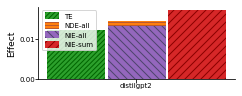

In [20]:
te = []
nde_all = []
nie_all = []
nie_sum = []
model_names = []
    
indirect_by_head = np.stack(df['indirect_effect_head'].to_numpy())
mean_sum_indirect_effect = indirect_by_head.sum(axis=(1, 2)).mean()
te.append(data['mean_total_effect'])
nde_all.append(data['mean_model_direct_effect'])
nie_all.append(data['mean_model_indirect_effect'])
nie_sum.append(mean_sum_indirect_effect)
model_names.append(model_version)

plt.figure(num=1, figsize=(3, 1.2))
width = .29
inds = np.arange(len(model_names))
spacing = 0.015
p1 = plt.bar(inds, te, width, color=palette[2], linewidth=0, hatch='/////', edgecolor='darkgreen')
p2 = plt.bar(inds + width + spacing, nie_all, width, color=palette[4], linewidth=0, hatch='\\\\\\',
              edgecolor='#4E456D')
p3 = plt.bar(inds + width + spacing, nde_all, width, bottom=nie_all, color=palette[1], linewidth=0,
              hatch='----', edgecolor='#BB592D')
p4 = plt.bar(inds + 2 * (width + spacing), nie_sum, width, color=palette[3], linewidth=0, hatch='///',
              edgecolor='darkred')

plt.gca().tick_params(axis='x', pad=0)
plt.gca().tick_params(axis='y', pad=0)
plt.gca().yaxis.labelpad = 3
plt.ylabel('Effect', size=9)
plt.xticks(inds + .3, model_names, size=7)
for tick in plt.gca().xaxis.get_minor_ticks():
    tick.label1.set_horizontalalignment('center')
plt.yticks(size=7)
leg = plt.legend((p1[0], p3[0], p2[0], p4[0]), ('TE', 'NDE-all', 'NIE-all', 'NIE-sum'), loc='upper left', fontsize=7)
for patch in leg.get_patches():
    patch.set_height(7)
    patch.set_y(-1)
sns.despine()
plt.subplots_adjust(left=0.08, right=0.99, top=0.99, bottom=0.15)
path = 'results/attention_intervention/'
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(f'{path}effects.pdf', format='pdf')